In [15]:
%load_ext autoreload
%autoreload 2
import pickle

import pandas as pd

import data_pre_processing
import dataset_pre_processing
import pre_training
import raw_data_processing
from raw_data_processing import process_PAMAP2_all_data, process_hhar_all_files, process_motion_sense_all_files, open_pickle
import numpy as np
import scipy.stats
import data_pre_processing
import self_har_models
import tensorflow as tf
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
with open('pickled_datasets/pamap.pickle', 'rb') as file:
    pamap_df = pickle.load(file)
with open('pickled_datasets/hhar.pickle', 'rb') as file:
    hhar_df = pickle.load(file)
with open('pickled_datasets/motionsense.pickle', 'rb') as file:
    motion_sense_df = pickle.load(file)

In [10]:
def concat_datasets(datasets, sensor_type):
    concated_datasets = {}
    ##TODO need to check key to see whether mag exists
    for df in datasets:
        concated_datasets.update(df[sensor_type])
    return concated_datasets

cdf = concat_datasets([pamap_df, hhar_df, motion_sense_df], "acc")

In [11]:
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(cdf)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)

{'IMU ankle': 0, 'IMU chest': 1, 'IMU hand': 2, 'Phone': 3, 'Watch': 4, 'iphone': 5}


In [12]:
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
    cdf, label_map, 6, 
    ['101', '102', '103', '104', '105', '106', '107', 'a', 'b', 'c', 'd', 'e', 'f', 'g', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'], 
    ["108", "109", "h", "i", "21", "22", "23", "24"], 400, 200, verbose=1
)

here
splitting training
normalising
getting mean
0
[-0.18597652  1.40292431  4.05411898]
[6.31367612 5.0870368  5.47022979]
normalising train set
normalisnig test
mapping
Test
(array(['IMU ankle', 'IMU chest', 'IMU hand', 'Phone', 'Watch', 'iphone'],
      dtype='<U9'), array([ 2070,  2076,  2071, 12825,   995,  1080]))
(array([0, 1, 2, 3, 4, 5]), array([ 2070,  2076,  2071, 12825,   995,  1080]))
-----------------
Train
(array(['IMU ankle', 'IMU chest', 'IMU hand', 'Phone', 'Watch', 'iphone'],
      dtype='<U9'), array([12224, 12270, 12221, 43567, 14100,  5550]))
(array([0, 1, 2, 3, 4, 5]), array([12224, 12270, 12221, 43567, 14100,  5550]))
-----------------
Training data shape: (79945, 400, 3)
Validation data shape: (19987, 400, 3)
Testing data shape: (21117, 400, 3)


In [30]:
test_model = self_har_models.create_1d_conv_core_model((400,3), "HAR")


In [31]:
print(test_model.summary())

Model: "HAR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 conv1d_27 (Conv1D)          (None, 377, 32)           2336      
                                                                 
 dropout_27 (Dropout)        (None, 377, 32)           0         
                                                                 
 conv1d_28 (Conv1D)          (None, 362, 64)           32832     
                                                                 
 dropout_28 (Dropout)        (None, 362, 64)           0         
                                                                 
 conv1d_29 (Conv1D)          (None, 355, 96)           49248     
                                                                 
 dropout_29 (Dropout)        (None, 355, 96)           0       

In [13]:
test_model = self_har_models.create_1d_conv_core_model((400,3), "HAR")
full_model = self_har_models.attach_full_har_classification_head(test_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
history = full_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

2023-10-25 12:13:22.963137: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 383736000 exceeds 10% of free system memory.
2023-10-25 12:13:23.290459: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 383736000 exceeds 10% of free system memory.


Epoch 1/10


2023-10-25 12:13:24.578752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-10-25 12:13:25.206765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2499/2499 [==============================] - ETA: 0s - loss: 0.2015 - categorical_accuracy: 0.9422 - auc: 0.9944 - precision: 0.9476 - recall: 0.9362

2023-10-25 12:13:36.997954: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 95937600 exceeds 10% of free system memory.
2023-10-25 12:13:37.089199: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 95937600 exceeds 10% of free system memory.


2499/2499 [==============================] - 16s 5ms/step - loss: 0.2015 - categorical_accuracy: 0.9422 - auc: 0.9944 - precision: 0.9476 - recall: 0.9362 - val_loss: 0.1795 - val_categorical_accuracy: 0.9550 - val_auc: 0.9965 - val_precision: 0.9601 - val_recall: 0.9403
Epoch 2/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.1427 - categorical_accuracy: 0.9590 - auc: 0.9969 - precision: 0.9614 - recall: 0.9569 - val_loss: 0.1529 - val_categorical_accuracy: 0.9575 - val_auc: 0.9973 - val_precision: 0.9624 - val_recall: 0.9515
Epoch 3/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1226 - categorical_accuracy: 0.9660 - auc: 0.9976 - precision: 0.9676 - recall: 0.9644 - val_loss: 0.1550 - val_categorical_accuracy: 0.9572 - val_auc: 0.9977 - val_precision: 0.9630 - val_recall: 0.9525
Epoch 4/10
2499/2499 [==============================] - 12s 5ms/step - loss: 0.1105 - categorical_accuracy: 0.9701 - auc: 0.9980 - precision: 0.9715 - recall: 0.9

660/660 [==============================] - 12s 18ms/step - loss: 0.7332 - categorical_accuracy: 0.8794 - auc: 0.9496 - precision: 0.8813 - recall: 0.8790


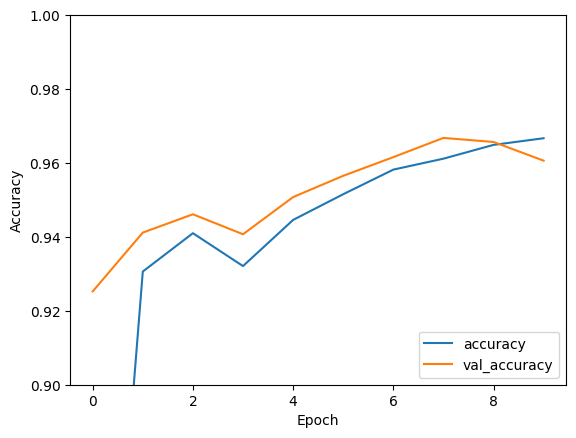

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.9, 1])
plt.legend(loc='lower right')

test_result = full_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)

In [24]:
self_har_models.save_model_results(full_model, user_datasets_processed[2][0],  user_datasets_processed[2][1], "test_results.txt")

660/660 [==============================] - 5s 7ms/step


In [22]:
print(test_result)

{'loss': 0.6247720122337341, 'categorical_accuracy': 0.8361983299255371, 'auc': 0.9624589681625366, 'precision': 0.8545987010002136, 'recall': 0.8294265270233154}


660/660 [==============================] - 1s 2ms/step


<Axes: >

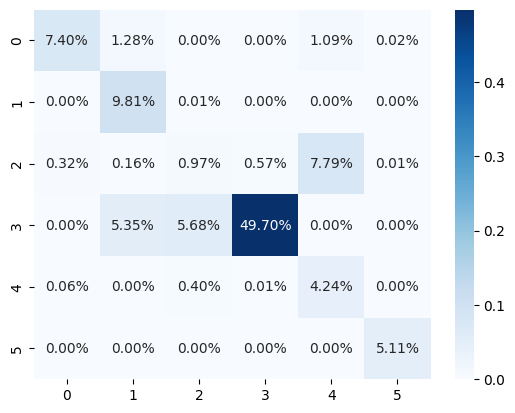

In [16]:
predicted_labels = np.argmax(full_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusion_mat/np.sum(confusion_mat), annot=True, 
            fmt='.2%', cmap='Blues')

In [33]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Conv1D(
        32, 24,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4)
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv1D(
        64, 16,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv1D(
    96, 8,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(l=1e-4),
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96))(x)
x = tf.keras.layers.Dense(96, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='sigmoid')(x)

this_model = tf.keras.Model(inputs, x, name="LSTM")


In [17]:
inputs = tf.keras.Input(shape=(400,3), name='input')
x = inputs
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(400))(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='sigmoid')(x)
LSTM_CNN_model = tf.keras.Model(inputs, x, name="LSTM-CNN")
print(LSTM_CNN_model.summary())

2023-10-25 12:19:18.915635: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 12:19:18.917437: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 12:19:18.918786: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "LSTM-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 3)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 800)              1292800   
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 10)                8010      
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
Total params: 1,300,920
Trainable params: 1,300,920
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
full_model = self_har_models.attach_full_har_classification_head(LSTM_CNN_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
history = full_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=10, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]))

2023-10-25 12:19:32.642506: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 12:19:32.644555: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 12:19:32.646147: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-10-25 12:19:33.690755: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 12:19:33.692805: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 12:19:33.694148: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2499/2499 [==============================] - ETA: 0s - loss: 0.6728 - categorical_accuracy: 0.7605 - auc: 0.9537 - precision: 0.8528 - recall: 0.6752

2023-10-25 12:21:27.848375: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-25 12:21:27.850320: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-25 12:21:27.851706: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2499/2499 [==============================] - 126s 49ms/step - loss: 0.6728 - categorical_accuracy: 0.7605 - auc: 0.9537 - precision: 0.8528 - recall: 0.6752 - val_loss: 0.2644 - val_categorical_accuracy: 0.9253 - val_auc: 0.9905 - val_precision: 0.9344 - val_recall: 0.9185
Epoch 2/10
2499/2499 [==============================] - 123s 49ms/step - loss: 0.2406 - categorical_accuracy: 0.9306 - auc: 0.9913 - precision: 0.9364 - recall: 0.9257 - val_loss: 0.1970 - val_categorical_accuracy: 0.9412 - val_auc: 0.9947 - val_precision: 0.9453 - val_recall: 0.9373
Epoch 3/10
2499/2499 [==============================] - 123s 49ms/step - loss: 0.2000 - categorical_accuracy: 0.9410 - auc: 0.9936 - precision: 0.9460 - recall: 0.9367 - val_loss: 0.1979 - val_categorical_accuracy: 0.9461 - val_auc: 0.9944 - val_precision: 0.9524 - val_recall: 0.9381
Epoch 4/10
2499/2499 [==============================] - 122s 49ms/step - loss: 0.2356 - categorical_accuracy: 0.9321 - auc: 0.9916 - precision: 0.9382 - rec

In [25]:
tf.saved_model.save(full_model, "saved_models")

INFO:tensorflow:Assets written to: saved_models/assets


INFO:tensorflow:Assets written to: saved_models/assets
